In [67]:
import os 
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
) 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### I. For the 20N dataset compare two classifiers NB and LR to identify the 20 different newsgroups.
####     o Create your own processing pipeline for the task and justify it.
####     o Divide the dataset into training (60%), validation (10%) and test (30%).
####     o Train NB and LR using the following vector representations:
####     ▪ tf (counts) representation (sklearn: CountVectorizer).
####     ▪ tfidf representation (sklearn: TfidfVectorizer).

In [68]:
path_20N = 'datasets/20news-18828/20news-18828/'

In [69]:
def preprocess_text(text):
    """
    input: text: str.
    función para normalizar el texto ingresado, también se aplica stemming para reducir el vocabulario, como usaremos más adelante stopwords
    puesto buscamos palabras que agregen valor semántico al texto para poder clasificar.
    """
    text = text.lower()
    ### Remover correos electrónicos
    text = re.sub(r'[\w\d]+@[\w\d]+\.[\w\d]+\.?[\w\d]*\.?[\w\d]*\.?[\w\d]*\.?[\w\d]*',' ',text)
    #### Reemplazar números con la etiqueta NUM
    text = re.sub(r'\d+', 'NUM', text)
    # Remover con un expresión regular carateres especiales (no palabras).
    text = re.sub(r'[^\w\s]', ' ', str(text))
    # remover __ 
    text = re.sub(r'_+',' ',str(text))
    # minúsculas
    text = text.lower()
    # stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    return text

In [70]:
def pipline_text(path20N):
    """ 
    Con esta función se lee el dataset 20N, normalizando cada texto y entregando lista de texto Normalizada y las categorias correspondientes, donde categorias
    es la clase de texto a la que pertenece el mismo. 
    """
    
    categoria = []
    texto = [] 

    for root, dirs, files in os.walk(path_20N):
        for file in files:
            categoria.append(root[root.rfind('/')+1:])
            with open(os.path.join(root,file),'r',encoding='latin-1') as file: 
                text = file.read()
                texto.append(preprocess_text(text))
    return texto,categoria
        

textos,categorias = pipline_text(path20N=path_20N)

In [71]:
## aplicamos la vectorización tf (term frequency)
vectorizer_tf = CountVectorizer(max_features=4000, stop_words=stopwords.words('english') )
texto_features_tf = vectorizer_tf.fit_transform(textos).toarray()
#Divide the dataset into training (60%), validation (10%) and test (30%).
x_temp_tf, x_test_tf, y_temp_tf, y_test_tf = train_test_split(texto_features_tf,categorias,test_size=0.3)
x_train_tf, x_val_tf, y_train_tf,y_val_tf = train_test_split(x_temp_tf,y_temp_tf,test_size=0.1)

In [72]:
## aplicamos la vectorización ( Term Frequency-Inverse Document Frequency)
vectorizer_tfidf = TfidfVectorizer(max_features=4000, stop_words=stopwords.words('english'))
texto_features_tfidf = vectorizer_tfidf.fit_transform(textos)
#Divide the dataset into training (60%), validation (10%) and test (30%).
x_temp_tfidf,x_test_tfidf,y_temp_tfidf,y_test_tfidf = train_test_split(texto_features_tfidf,categorias,test_size=0.3)
x_train_tfidf,x_val_tfidf,y_train_tfidf,y_val_tfidf = train_test_split(x_temp_tfidf,y_temp_tfidf)

### Train NB and LR

In [73]:
### Hacemos un entrenamiento tradicional para ver los resultados
### y tomar este modelo como linea base de comparación
nb_tf = MultinomialNB()
nb_tf.fit(x_train_tf,y_train_tf)  ## 
predictions_tf_validation = nb_tf.predict(x_val_tf)  ## se evalua el comportamiento del modelo sin ver compremeter los datos de testeo
print(f'tf Naive Bayes accuracy score validation: {accuracy_score(y_val_tf,predictions_tf_validation)}, params:{nb_tf.get_params()}')
## pronóstico
predictions_tf = nb_tf.predict(x_test_tf)
print(f"tf Naive Bayes accuracy score : {accuracy_score(y_test_tf,predictions_tf)}, params:{nb_tf.get_params()}")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_tfidf,y_train_tfidf) 
predictions_tfidf_validation = nb_tfidf.predict(x_val_tfidf)   ## se evalua el comportamiento del modelo sin ver compremeter los datos de testeo
print(f'tfidf Naive Bayes accuracy score validation: {accuracy_score(y_val_tfidf,predictions_tfidf_validation)}, params:{nb_tf.get_params()}')
#predicción testeo
predictions_tfidf = nb_tfidf.predict(x_test_tfidf)
print(f"tfidf Naive Bayes accuracy_score: {accuracy_score(y_test_tfidf,predictions_tfidf)}, params: {nb_tfidf.get_params()}")

tf Naive Bayes accuracy score validation: 0.7890743550834598, params:{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
tf Naive Bayes accuracy score : 0.789166224110462, params:{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
tfidf Naive Bayes accuracy score validation: 0.839453717754173, params:{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
tfidf Naive Bayes accuracy_score: 0.8245707204815012, params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [74]:
### Hacemos un entrenamiento tradicional para ver los resultados
### y tomar este modelo como linea base de comparación
logistic_model_SGD_tf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.0001)
logistic_model_SGD_tf.fit(x_train_tf,y_train_tf)
predictions_SGD_tf_validation = logistic_model_SGD_tf.predict(x_val_tf)  ## se evalua el comportamiento del modelo sin ver compremeter los datos de testeo
print(f'tf accuracy_score validation: {accuracy_score(y_val_tf,predictions_SGD_tf_validation)}')
#predicción testeo del modelo
predictions_SGD_tf = logistic_model_SGD_tf.predict(x_test_tf)
print(f'tf accuracy_score: {accuracy_score(y_test_tf,predictions_SGD_tf)}')

logistic_model_SGD_tfidf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.0001)
logistic_model_SGD_tfidf.fit(x_temp_tfidf,y_temp_tfidf)
predictions_SGD_tfidf_validation = logistic_model_SGD_tfidf.predict(x_val_tfidf) ## se evalua el comportamiento del modelo sin ver compremeter los datos de testeo
print(f'tfidf accuracy_score validation: {accuracy_score(y_val_tfidf,predictions_SGD_tfidf_validation)}')
#predicción testeo del modelo
predictions_SGD_tfidf = logistic_model_SGD_tfidf.predict(x_test_tfidf)
print(f'tfidf accuracy_score: {accuracy_score(y_test_tfidf,predictions_SGD_tfidf)}')

tf accuracy_score validation: 0.7412746585735963
tf accuracy_score: 0.7530536378120021
tfidf accuracy_score validation: 0.7535660091047041
tfidf accuracy_score: 0.7061426801203753


### Investigate cross-validation technique.
### o Explain what the strategy consists of and what it is used for.

 cross validation es un método utilizado para evaluar el rendimiento de un modelo, su principal objetivo es medir cuán bien el modelo generaliza a datos no vistos,  ya que por cada ronda de entrenamiento dentro del conjunto de entrenamiento estima las métricas seleccionadas, y como está dentro del conjunto de entrenamiento da una mejor idea de como se comportará con un conjunto de datos nuevos.

#### Procedimiento

Dividir los datos de entrenamiento en "k" subconjuntos (particiones para ser exactos) o "folds", cada partición se selecciona como conjunto de prueba y se entrena con las k-1 particiones restantes, evaluando las k-1 particiones frente al conjunto de prueba con las métricas de evaluación (esto se hace k veces).

Una vez completadas las k iteraciones, se calcula la media de las métricas de evaluación (como precisión, error cuadrático medio, F1-score, etc.) en cada uno de los folds.

### Compare the results of NB and LR using 10-fold cross validation


In [75]:
scoring_param = ['accuracy','f1_macro', 'precision_macro', 'recall_macro','f1_micro', 'precision_micro', 'recall_micro']

In [78]:
## para Naive Bayes buscamos el alpha más adecuado para suavizar con laplace, 
## usualmente alpha=1 y usamos el método de crosvalidation.
grid = {'alpha':[0.001,0.01,0.1,1,10]}  # buscamos sobre estos alphas para ver cuál es mejor
nb_tf_crossval = MultinomialNB()
grid_search_tf_crossval = GridSearchCV(nb_tf_crossval,grid,scoring=scoring_param,refit='f1_macro',cv=10) # 10 folder y se elige f1_macro como criterio de evaluación para seleccionar alpha
grid_search_tf_crossval.fit(x_temp_tf,y_temp_tf)  # x_temp_tf,y_temp_tf = training+validation sets.
print(f"mejores alpha: {grid_search_tf_crossval.best_params_}, mejor score: {grid_search_tf_crossval.best_score_}")
predictions_nb_tf_crossval = grid_search_tf_crossval.predict(x_test_tf)
print(f"tf cross validations accuracy_score: {accuracy_score(y_test_tf,predictions_nb_tf_crossval)}")


c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


mejores alpha: {'alpha': 0.01}, mejor score: 0.7842316676414612
tf cross validations accuracy_score: 0.7974862807576563


In [54]:
results_nb_tf_cv = grid_search_tf_crossval.cv_results_

### promedio de cada métrica 'accuracy','f1_macro', 'precision_macro', 'recall_macro' por cada parámetro [0.001,0.01,0.1,1,10] para el proceso de cross-validation
### naive-bayes representación rf cross-validation
print(f"""
 mean_test_accuracy: {results_nb_tf_cv['mean_test_accuracy']}\n
 mean_test_f1_macro: {results_nb_tf_cv['mean_test_f1_macro']}\n
 mean_test_precision_macro: {results_nb_tf_cv['mean_test_precision_macro']}\n 
 mean_test_recall_macro: {results_nb_tf_cv['mean_test_recall_macro']} \n
 mean_test_f1_micro: {results_nb_tf_cv['mean_test_f1_micro']}\n
 mean_test_precision_micro: {results_nb_tf_cv['mean_test_precision_micro']}\n 
 mean_test_recall_micro: {results_nb_tf_cv['mean_test_recall_micro']} \n
 """)



 mean_test_accuracy: [0.79399011 0.79664559 0.79839101 0.79277586 0.76970969]

 mean_test_f1_macro: [0.77643394 0.77880219 0.7803681  0.77414486 0.74616404]

 mean_test_precision_macro: [0.79906492 0.80165087 0.79991773 0.78978332 0.77186485]
 
 mean_test_recall_macro: [0.79212197 0.79462618 0.79639837 0.79025008 0.76313321] 

 mean_test_f1_micro: [0.79399011 0.79664559 0.79839101 0.79277586 0.76970969]

 mean_test_precision_micro: [0.79399011 0.79664559 0.79839101 0.79277586 0.76970969]
 
 mean_test_recall_micro: [0.79399011 0.79664559 0.79839101 0.79277586 0.76970969] 

 


#

In [55]:
## para Naive Bayes buscamos el alpha más adecuado para suavizar con laplace, 
## usualmente alpha=1 y usamos el método de crosvalidation.
grid = {'alpha':[0.001,0.01,0.1,1,10]}  # buscamos sobre estos alphas para ver cuál es mejor
nb_tfid_crossval = MultinomialNB()
grid_search_tfid_crossval = GridSearchCV(nb_tfid_crossval,grid,scoring=scoring_param,refit='f1_macro',cv=10) # 10 folder y se elige f1_macro como criterio de evaluación para seleccionar alpha
grid_search_tfid_crossval.fit(x_temp_tfidf,y_temp_tfidf) # x_temp_tf,y_temp_tf = training+validation sets.
print(f"mejores alpha: {grid_search_tfid_crossval.best_params_}, mejor score: {grid_search_tfid_crossval.best_score_}")
predictions_nb_tfid_crossval = grid_search_tfid_crossval.predict(x_test_tfidf)
print(f"tfid cross validations accuracy_score: {accuracy_score(y_test_tfidf,predictions_nb_tfid_crossval)}")



c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

mejores alpha: {'alpha': 0.01}, mejor score: 0.8506464046648888
tfid cross validations accuracy_score: 0.8555496548061604


In [56]:
results_nb_tfidf_cv = grid_search_tfid_crossval.cv_results_

### promedio de cada métrica 'accuracy','f1_macro', 'precision_macro', 'recall_macro' por cada parámetro [0.001,0.01,0.1,1,10] para el proceso de cross-validation
### naive-bayes representación tfidf cross-validation
print(f"""
 mean_test_accuracy: {results_nb_tfidf_cv['mean_test_accuracy']}\n
 mean_test_f1_macro: {results_nb_tfidf_cv['mean_test_f1_macro']}\n
 mean_test_precision_macro: {results_nb_tfidf_cv['mean_test_precision_macro']}\n 
 mean_test_recall_macro: {results_nb_tfidf_cv['mean_test_recall_macro']} \n
 mean_test_f1_micro: {results_nb_tfidf_cv['mean_test_f1_micro']}\n
 mean_test_precision_micro: {results_nb_tfidf_cv['mean_test_precision_micro']}\n 
 mean_test_recall_micro: {results_nb_tfidf_cv['mean_test_recall_micro']} \n
 """)


 mean_test_accuracy: [0.84945697 0.85583101 0.85583107 0.83655783 0.78245743]

 mean_test_f1_macro: [0.84417685 0.8506464  0.8495023  0.82234257 0.75538335]

 mean_test_precision_macro: [0.85090281 0.85764957 0.8581787  0.84966326 0.80051085]
 
 mean_test_recall_macro: [0.8436377  0.84987074 0.84878959 0.82446674 0.76421295] 

 mean_test_f1_micro: [0.84945697 0.85583101 0.85583107 0.83655783 0.78245743]

 mean_test_precision_micro: [0.84945697 0.85583101 0.85583107 0.83655783 0.78245743]
 
 mean_test_recall_micro: [0.84945697 0.85583101 0.85583107 0.83655783 0.78245743] 

 


In [57]:
param_grid_SGVclassifier = {
    'learning_rate': ['constant'],
    'eta0': [0.001, 0.01, 0.1, 1],  
}

sgvclas_tf_crv = SGDClassifier(loss='log_loss',max_iter=1000,tol=0.001)
grid_search_sgvclas_tf_crv = GridSearchCV(sgvclas_tf_crv,param_grid_SGVclassifier,scoring=scoring_param,refit='f1_macro',cv=10) # 10 folder y se elige f1_macro como criterio de evaluación para seleccionar alpha
grid_search_sgvclas_tf_crv.fit(x_temp_tf,y_temp_tf)  # x_temp_tf,y_temp_tf = training+validation sets.
print(f'mejores params: {grid_search_sgvclas_tf_crv.best_params_}, mejor score: {grid_search_sgvclas_tf_crv.best_score_}')
predictions_sgvclass_tf_crv = grid_search_sgvclas_tf_crv.predict(x_test_tf)
print(f'tf score sgv crossv: {accuracy_score(y_test_tf,predictions_sgvclass_tf_crv)}')

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


mejores params: {'eta0': 0.001, 'learning_rate': 'constant'}, mejor score: 0.8004635900938222
tf score sgv crossv: 0.7735882457072049


In [58]:
results_sgvclas_tf_cv = grid_search_sgvclas_tf_crv.cv_results_

### promedio de cada métrica 'accuracy','f1_macro', 'precision_macro', 'recall_macro' por cada parámetro [0.001, 0.01, 0.1, 1] para el proceso de cross-validation
### SGD clasiffier representación tf cross-validation
print(f"""
 mean_test_accuracy: {results_sgvclas_tf_cv['mean_test_accuracy']}\n
 mean_test_f1_macro: {results_sgvclas_tf_cv['mean_test_f1_macro']}\n
 mean_test_precision_macro: {results_sgvclas_tf_cv['mean_test_precision_macro']}\n 
 mean_test_recall_macro: {results_sgvclas_tf_cv['mean_test_recall_macro']} \n
 mean_test_f1_micro: {results_sgvclas_tf_cv['mean_test_f1_micro']}\n
 mean_test_precision_micro: {results_sgvclas_tf_cv['mean_test_precision_micro']}\n 
 mean_test_recall_micro: {results_sgvclas_tf_cv['mean_test_recall_micro']} \n
 """)


 mean_test_accuracy: [0.8040084  0.74034322 0.6464091  0.40625588]

 mean_test_f1_macro: [0.80046359 0.73398461 0.65426671 0.41555738]

 mean_test_precision_macro: [0.81593267 0.76581889 0.72962807 0.62140136]
 
 mean_test_recall_macro: [0.7998933  0.73753935 0.64397493 0.40503918] 

 mean_test_f1_micro: [0.8040084  0.74034322 0.6464091  0.40625588]

 mean_test_precision_micro: [0.8040084  0.74034322 0.6464091  0.40625588]
 
 mean_test_recall_micro: [0.8040084  0.74034322 0.6464091  0.40625588] 

 


In [59]:
param_grid_SGVclassifier = {
    'learning_rate': ['constant'],
    'eta0': [0.001, 0.01, 0.1, 1],  
}

sgvclas_tfidf_crv = SGDClassifier(loss='log_loss',max_iter=1000,tol=0.001)
grid_search_sgvclas_tfidf_crv = GridSearchCV(sgvclas_tfidf_crv,param_grid_SGVclassifier,scoring=scoring_param,refit='f1_macro',cv=10) # 10 folder y se elige f1_macro como criterio de evaluación para seleccionar alpha
grid_search_sgvclas_tfidf_crv.fit(x_temp_tfidf,y_temp_tfidf)  # x_temp_tf,y_temp_tf = training+validation sets.
print(f'mejores params: {grid_search_sgvclas_tfidf_crv.best_params_}, mejor score: {grid_search_sgvclas_tfidf_crv.best_score_}')
predictions_sgvclass_tfidf_crv = grid_search_sgvclas_tfidf_crv.predict(x_test_tfidf)
print(f'tfidf score sgv crossv: {accuracy_score(y_test_tfidf,predictions_sgvclass_tfidf_crv)}')


mejores params: {'eta0': 1, 'learning_rate': 'constant'}, mejor score: 0.8437794456496548
tfidf score sgv crossv: 0.8474066206408214


In [60]:
results_sgvclas_tfidf_cv = grid_search_sgvclas_tfidf_crv.cv_results_

### promedio de cada métrica 'accuracy','f1_macro', 'precision_macro', 'recall_macro' por cada parámetro [0.001, 0.01, 0.1, 1] para el proceso de cross-validation
### SGD classifier representación tfidf cross-validation
print(f"""
 mean_test_accuracy: {results_sgvclas_tfidf_cv['mean_test_accuracy']}\n
 mean_test_f1_macro: {results_sgvclas_tfidf_cv['mean_test_f1_macro']}\n
 mean_test_precision_macro: {results_sgvclas_tfidf_cv['mean_test_precision_macro']}\n 
 mean_test_recall_macro: {results_sgvclas_tfidf_cv['mean_test_recall_macro']} \n
 mean_test_f1_micro: {results_sgvclas_tfidf_cv['mean_test_f1_micro']}\n
 mean_test_precision_micro: {results_sgvclas_tfidf_cv['mean_test_precision_micro']}\n 
 mean_test_recall_micro: {results_sgvclas_tfidf_cv['mean_test_recall_micro']} \n
 """)


 mean_test_accuracy: [0.74057256 0.82252066 0.84854696 0.84907726]

 mean_test_f1_macro: [0.72836632 0.81063561 0.84223263 0.84377945]

 mean_test_precision_macro: [0.7972828  0.83002042 0.85122207 0.85243199]
 
 mean_test_recall_macro: [0.72652516 0.8118738  0.84137424 0.84265568] 

 mean_test_f1_micro: [0.74057256 0.82252066 0.84854696 0.84907726]

 mean_test_precision_micro: [0.74057256 0.82252066 0.84854696 0.84907726]
 
 mean_test_recall_micro: [0.74057256 0.82252066 0.84854696 0.84907726] 

 


### III. Evaluate models using the test set:
### o Report precision, recall, and F1 with the micro and micro average results.
### o What is the best model?

In [61]:
# presicion macro
precision_macro_nb_tf = precision_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
precision_macro_nb_tfidf = precision_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
precision_macro_svgclass_tf  = precision_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
presicion_macro_svgclass_tfidf = precision_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# recall macro
recall_macro_nb_tf = recall_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
recall_macro_nb_tfidf = recall_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
recall_macro_svgclass_tf = recall_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
recall_macro_svgclass_tfidf = recall_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# f1 score macro
f1score_macro_nb_tf = f1_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
f1score_macro_nb_tfidf = f1_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
f1score_macro_svgclass_tf = f1_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
f1score_macro_svgclass_tfidf = f1_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# presicion micro
precision_micro_nb_tf = precision_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
precision_micro_nb_tfidf = precision_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
precision_micro_svgclass_tf  = precision_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
presicion_micro_svgclass_tfidf = precision_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')

# recall micro
recall_micro_nb_tf = recall_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
recall_micro_nb_tfidf = recall_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
recall_micro_svgclass_tf = recall_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
recall_micro_svgclass_tfidf = recall_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')

# f1 score macro
f1score_micro_nb_tf = f1_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
f1score_micro_nb_tfidf = f1_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
f1score_micro_svgclass_tf = f1_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
f1score_micro_svgclass_tfidf = f1_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')



In [62]:
results = {'precision_macro_nb_tf':precision_macro_nb_tf,
'precision_macro_nb_tfidf':precision_macro_nb_tfidf,
'precision_macro_svgclass_tf':precision_macro_svgclass_tf,
'presicion_macro_svgclass_tfidf':presicion_macro_svgclass_tfidf,
'recall_macro_nb_tf':recall_macro_nb_tf,
'recall_macro_nb_tfidf':recall_macro_nb_tfidf,
'recall_macro_svgclass_tf':recall_macro_svgclass_tf,
'recall_macro_svgclass_tfidf':recall_macro_svgclass_tfidf,
'f1score_macro_nb_tf':f1score_macro_nb_tf,
'f1score_macro_nb_tfidf':f1score_macro_nb_tfidf,
'f1score_macro_svgclass_tf':f1score_macro_svgclass_tf,
'f1score_macro_svgclass_tfidf':f1score_macro_svgclass_tfidf,
'precision_micro_nb_tf':precision_micro_nb_tf,
'precision_micro_nb_tfidf':precision_micro_nb_tfidf,
'precision_micro_svgclass_tf':precision_micro_svgclass_tf,
'presicion_micro_svgclass_tfidf':presicion_micro_svgclass_tfidf,
'recall_micro_nb_tf':recall_micro_nb_tf,
'recall_micro_nb_tfidf':recall_micro_nb_tfidf,
'recall_micro_svgclass_tf':recall_micro_svgclass_tf,
'recall_micro_svgclass_tfidf':recall_micro_svgclass_tfidf,
'f1score_micro_nb_tf':f1score_micro_nb_tf,
'f1score_micro_nb_tfidf':f1score_micro_nb_tfidf,
'f1score_micro_svgclass_tf':f1score_micro_svgclass_tf,
'f1score_micro_svgclass_tfidf':f1score_micro_svgclass_tfidf,
}

In [63]:
for key,value in results.items(): 
    print(f'{key}: {value}')

precision_macro_nb_tf: 0.8042972294130031
precision_macro_nb_tfidf: 0.8520818501609814
precision_macro_svgclass_tf: 0.7743478120296314
presicion_macro_svgclass_tfidf: 0.8457299434955168
recall_macro_nb_tf: 0.800935365135681
recall_macro_nb_tfidf: 0.8475417360326691
recall_macro_svgclass_tf: 0.7690923734274115
recall_macro_svgclass_tfidf: 0.8368259938598703
f1score_macro_nb_tf: 0.7860219240413978
f1score_macro_nb_tfidf: 0.8480891404454125
f1score_macro_svgclass_tf: 0.7588528359789202
f1score_macro_svgclass_tfidf: 0.837684856798942
precision_micro_nb_tf: 0.8084616746326784
precision_micro_nb_tfidf: 0.8555496548061604
precision_micro_svgclass_tf: 0.7735882457072049
presicion_micro_svgclass_tfidf: 0.8474066206408214
recall_micro_nb_tf: 0.8084616746326784
recall_micro_nb_tfidf: 0.8555496548061604
recall_micro_svgclass_tf: 0.7735882457072049
recall_micro_svgclass_tfidf: 0.8474066206408214
f1score_micro_nb_tf: 0.8084616746326784
f1score_micro_nb_tfidf: 0.8555496548061604
f1score_micro_svgclas

Dado los resultados expresados en la siguiente tabla, el modelo Naive-Bayes con representación vectorial tfidf se elige como mejor modelo: 
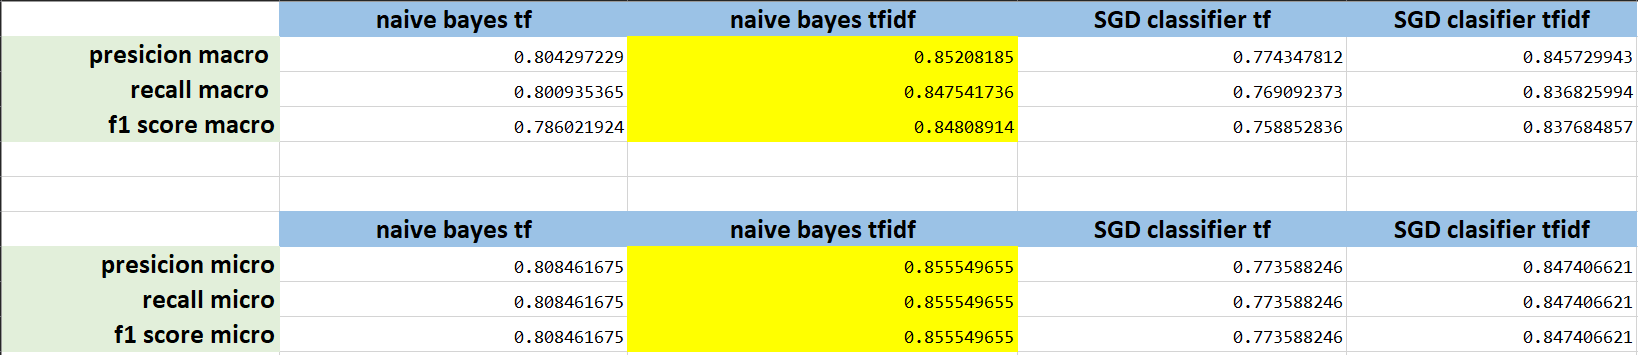